In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
MARKET_ETF = 'SPY'
TREASURY_RATE = '^TNX' # 10yr
gics2etf = {
    '10': 'XLE',
    '15': 'XLB',
    '20': 'XLI',
    '25': 'XLY',
    '30': 'XLP',
    '35': 'XLV',
    '40': 'XLF',
    '45': 'XSD',
    '50': 'XTL',
    '55': 'XLU',
    '60': 'XLRE'
}
holding2shares = {
    'CVS': 900,
    'SPY': 1100,
    'QQQ': 850,
    'DHI': 666,
    'PLD': 546,
    'XLF': 1915,
    'SPYV': 1785,
    'IAU': 1500,
    'BA': 150,
    'SWAN': 1375,
    'APG': 3043,
    'SUMO': 1411,
    'NNOX': 1064,
    'BA': 300,
}
PERIOD = '3mo'
NUM_TRADING_DAYS = 252

Pull tickers from yahoo finance

In [3]:
gics_close = {gics: yf.Ticker(etf).history(period=PERIOD)['Close']
              for gics, etf in gics2etf.items()}
environment_close = {
    MARKET_ETF: yf.Ticker(MARKET_ETF).history(period=PERIOD)['Close'],
    TREASURY_RATE: yf.Ticker(TREASURY_RATE).history(period=PERIOD)['Close']
}
holdings_close = {ticker + '_holding': yf.Ticker(ticker).history(period=PERIOD)['Close']
                  for ticker in holding2shares.keys()}
close = {**gics_close, **environment_close, **holdings_close}
close = pd.DataFrame(close)

Calculate log returns and use daily log return for the treasury rate (yahoo finance didn't have shorter notes)

In [4]:
treasury_logret = np.log(1 + close[TREASURY_RATE] / 100) / (10 * NUM_TRADING_DAYS)

In [5]:
logret = close.drop(TREASURY_RATE, axis=1)
logret = np.log(logret) - np.log(logret.shift(1))
logret = logret.join(treasury_logret)
logret = logret.dropna()

Calculate risk premiums and regress to find beta

In [6]:
gics_col = list(gics2etf.keys())
holdings_col = [t + '_holding' for t in holding2shares.keys()]
assets_col = gics_col + holdings_col

asset_rp = logret[assets_col].values - logret[[TREASURY_RATE]].values
market_rp = logret[MARKET_ETF] - logret[TREASURY_RATE]
X = np.vstack([np.ones_like(market_rp), market_rp]).T
betas = (np.linalg.pinv(X) @ asset_rp)[1]

Residualize the risk premiums plot correlation heatmap

In [12]:
market_rp_tiled = np.tile(market_rp.values.reshape(-1, 1), (1, len(gics_col)))
gics_residuals = logret[gics_col] - logret[[TREASURY_RATE]].values - betas[:len(gics_col)] * market_rp_tiled

<AxesSubplot:>

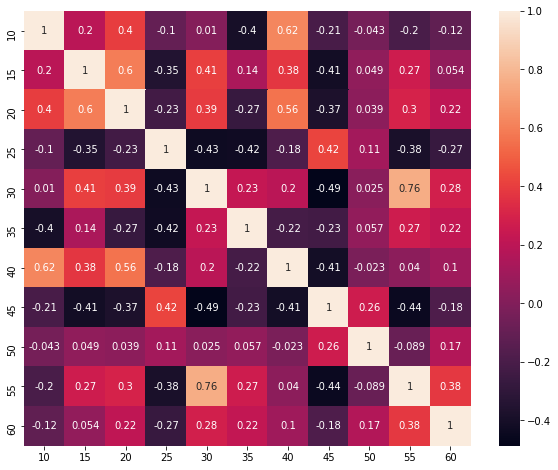

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(gics_residuals.corr(), annot=True)

10, 15, 20, 40 gics seem to have some common factor. Makes sense because these are defensive industry gics.

Now calculate holdings residuals

In [14]:
market_rp_tiled = np.tile(market_rp.values.reshape(-1, 1), (1, len(holdings_col)))
holdings_residuals = logret[holdings_col] - logret[[TREASURY_RATE]].values - betas[-len(holdings_col):] * market_rp_tiled

<AxesSubplot:>

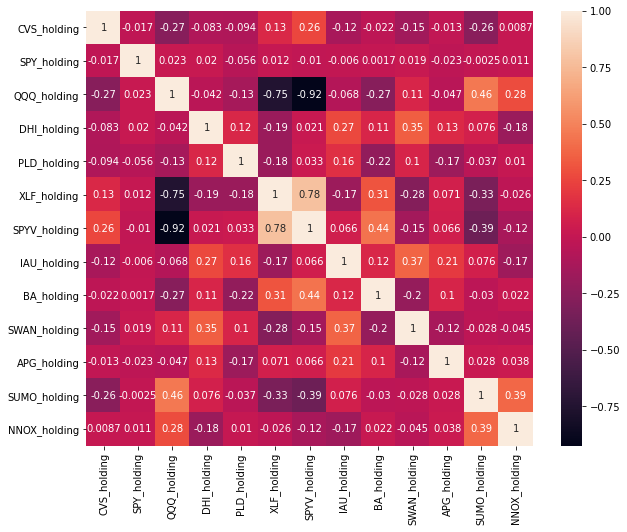

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(holdings_residuals.corr(), annot=True)

In [16]:
X = np.hstack([np.ones((gics_residuals.shape[0], 1)), gics_residuals.values])
exposures = np.linalg.pinv(X) @ holdings_residuals
exposures.index = ['constant'] + list(gics2etf.keys())

Our exposures per holding are

In [17]:
values = {ticker: shares * close[ticker + '_holding'].iloc[-1]
          for ticker, shares in holding2shares.items()}
total_value = sum(values.values())
weights = np.array([value / total_value for value in values.values()])

In [18]:
weights

array([0.06933271, 0.34273668, 0.21081887, 0.04040358, 0.05969187,
       0.05227558, 0.05147025, 0.03598719, 0.04030608, 0.03136938,
       0.04668266, 0.0111613 , 0.00776384])

In [19]:
exposures

,CVS_holding,SPY_holding,QQQ_holding,DHI_holding,PLD_holding,XLF_holding,SPYV_holding,IAU_holding,BA_holding,SWAN_holding,APG_holding,SUMO_holding,NNOX_holding
constant,0.002944,-1.373803e-19,-0.000364,0.000936,0.000599,1.080754e-17,0.000142,-0.000032,-0.000541,-0.000624,0.003318,-0.004465,-0.009197
10,0.005003,2.365796e-19,-0.061903,-0.020508,0.094091,3.509854e-16,0.103271,0.133938,0.665075,-0.065307,-0.462208,0.202089,-0.513413
15,0.040854,3.658316e-18,0.009792,0.052600,-0.043398,2.655429e-16,0.049046,0.388912,0.261728,0.180932,0.199006,0.720873,-0.080387
20,-0.467472,-4.359013e-18,-0.270165,1.718741,-0.097337,-2.448802e-16,0.154653,0.321100,0.854100,0.014178,0.797632,-1.291838,-3.693337
25,0.166026,-2.232691e-18,0.006024,0.168898,-0.079948,2.374443e-16,0.087127,0.112391,0.756251,-0.168192,0.800452,-0.388960,0.397002
30,0.871989,-6.125522e-19,-0.131929,0.208593,0.131780,2.289519e-16,0.164131,-0.114598,-1.187575,-0.028987,0.095971,-1.881393,0.253501
35,0.752746,-6.963819e-18,-0.160465,0.270002,0.399394,3.440041e-16,0.130542,0.359422,-1.169960,-0.142358,0.204553,-0.367168,-1.198447
40,0.317561,4.144228e-18,-0.210784,-1.043421,-0.269488,1.000000e+00,0.201823,-0.418543,-0.575966,-0.168604,0.328411,-0.699510,1.781531
45,-0.178553,2.639782e-18,0.061592,0.053726,0.118985,2.111803e-16,-0.029954,0.080436,-0.516189,-0.007806,-0.112368,0.492741,-0.015496
50,0.446200,6.015284e-18,0.017463,0.183680,-0.315376,5.703030e-17,0.062597,-0.078738,0.981742,0.032519,0.413448,0.806182,2.388344


In [20]:
(exposures * weights).sum(axis=1)

constant    0.000199
10          0.003670
15          0.053889
20          0.022794
25          0.084676
30         -0.010064
35          0.017288
40         -0.040211
45         -0.009685
50          0.111034
55         -0.010312
60          0.068034
dtype: float64

In [26]:
sum(pd.Series(betas, index=assets_col).filter(regex="_holding") * weights)

1.1370176359068906